In [3]:
import numpy as np
import matplotlib.pyplot as plt # Collect coords into list
import osm

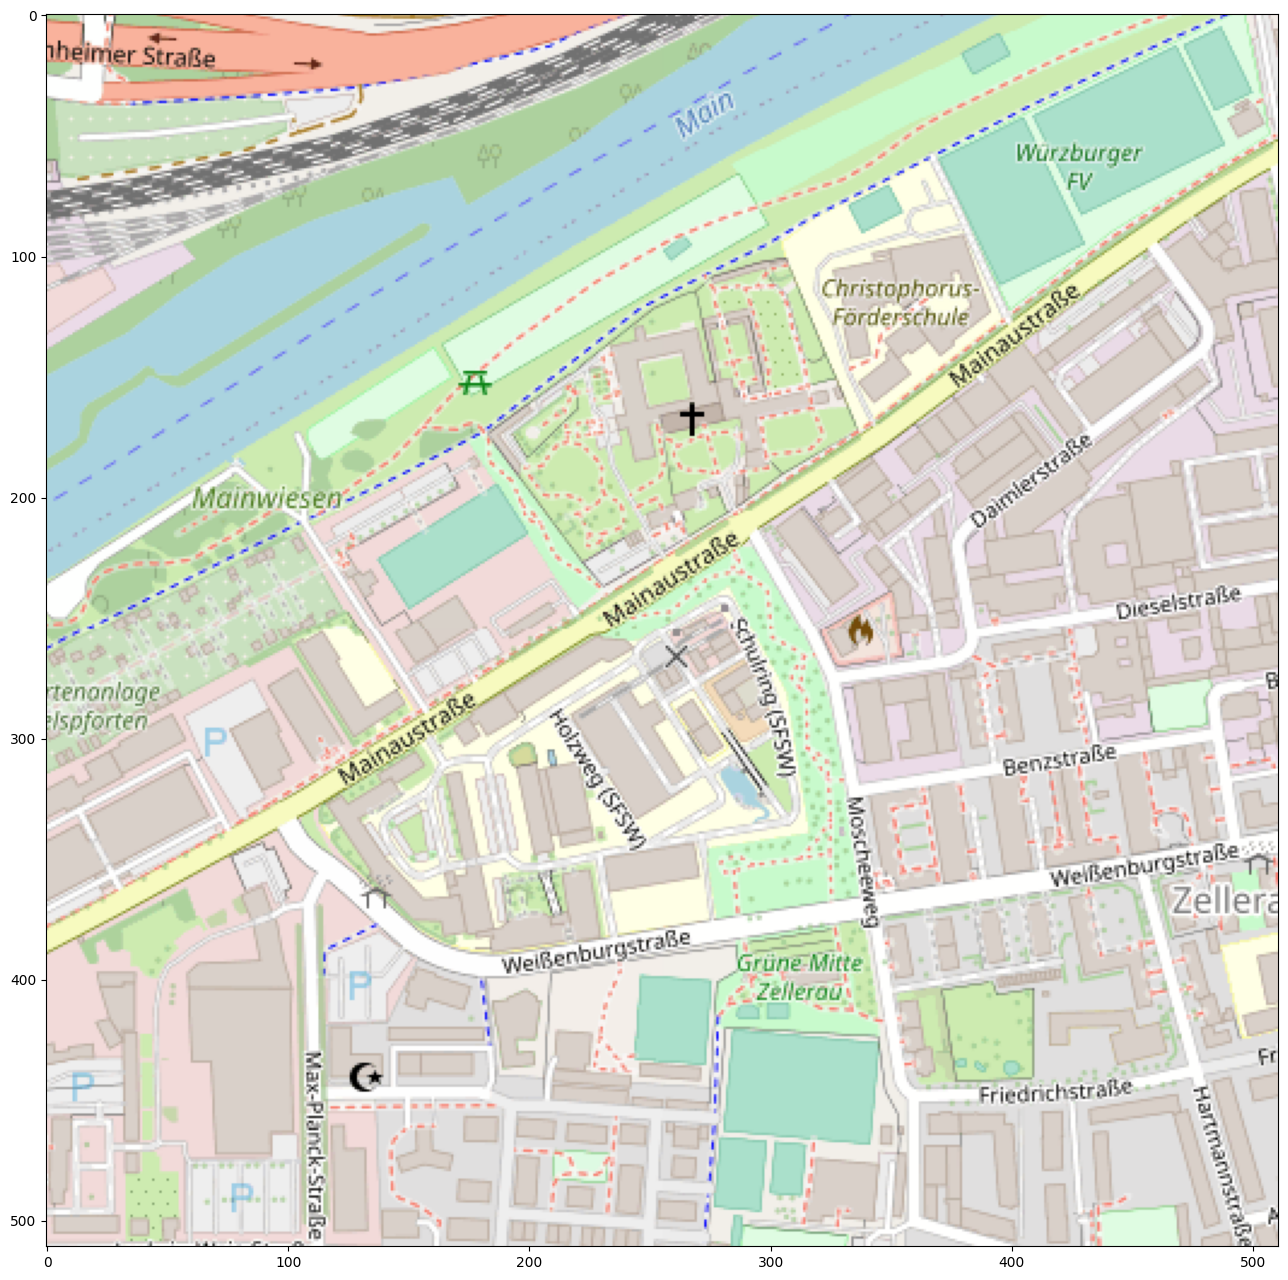

In [19]:
# Example
op = osm.Overpass()
buildings = op.getBuildingsFootprints(roi=[49.7955670752582, 9.89987744122153, 49.802298332928636, 9.909039867216649])
image_tile = op.getImageTile(lat=49.7955670752582, lon=9.89987744122153, delta_lat=0.005,  delta_long=0.005, zoom=16)
fig = plt.figure(figsize=(16,16))
plt.imshow(np.asarray(image_tile))
plt.show()

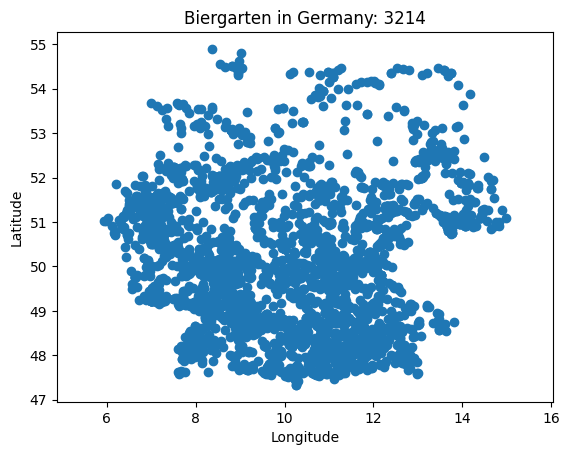

In [4]:
# Example
import requests
import json

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="DE"][admin_level=2];
(node["amenity"="biergarten"](area);
 way["amenity"="biergarten"](area);
 rel["amenity"="biergarten"](area);
);
out center;
"""
response = requests.get(overpass_url,
                        params={'data': overpass_query})
data = response.json()
coords = []
for element in data['elements']:
  if element['type'] == 'node':
    lon = element['lon']
    lat = element['lat']
    coords.append((lon, lat))
  elif 'center' in element:
    lon = element['center']['lon']
    lat = element['center']['lat']
    coords.append((lon, lat))# Convert coordinates into numpy array
X = np.array(coords)
plt.plot(X[:, 0], X[:, 1], 'o')
plt.title(f'Biergarten in Germany: {len(coords)}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()